In [1]:
!pip install wheel==0.37.1 setuptools==59.6.0
!pip install gym[atari,accept-rom-license]==0.21.0 tensorflow-probability==0.19.0 tqdm==4.64.1

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
from math import ceil
from typing import Iterable, Tuple, List, Callable
from dataclasses import dataclass, field

import gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras import Model
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.layers import \
    Layer, Input, Conv2D, Conv2DTranspose, Lambda, \
    Dropout, Reshape, Flatten, Dense, Concatenate, \
    Bidirectional, GRU, LSTM, Activation

In [3]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.11.0
/device:GPU:0


In [4]:
@dataclass
class DreamerSettings:
    action_dims: List[int]
    obs_dims: List[int]
    obs_enc_dims: List[int]
    repr_dims: List[int]
    hidden_dims: List[int]
    dropout_rate: float = 0.2
    codebook_size: int = 32

    @property
    def repr_dims_flat(self) -> int:
        return int(tf.reduce_prod(self.repr_dims).numpy())

    @property
    def z_quant_dims_flat(self) -> int:
        return int(tf.reduce_prod(self.obs_enc_dims).numpy())

    @property
    def padded_action_dims(self) -> int:
        return ceil(self.action_dims[0] / self.hidden_dims[0]) * self.hidden_dims[0]

    @property
    def rnn_input_dims_flat(self) -> int:
        return self.z_quant_dims_flat + self.padded_action_dims

In [5]:
settings = DreamerSettings([1], [64, 64, 3], [4, 4, 64], [32, 1024], [512])

# Train VAE Model as Latent State Encoder

## Generate Dataset

In [6]:
def sample_obs(env: gym.Env, num_obs: int, proprocess_image) -> tf.data.Dataset:
    all_obs = []
    done = False
    obs = env.reset()
    all_obs.append(obs)
    for i in tqdm(range(num_obs)):
        if i < len(all_obs):
            continue
        action = env.action_space.sample()
        obs, reward, done, _ = env.step(action)
        all_obs.append(obs)
        if done and len(all_obs) < num_obs:
            obs = env.reset()
            all_obs.append(obs)
    # TODO: this allocates way to much memory, process in smaller slices
    obs = proprocess_image(np.array(all_obs))
    return tf.data.Dataset.from_tensor_slices(tensors=(obs))


def generate_datasets(
        env: gym.Env, settings: DreamerSettings,
        batch_size: int, timesteps: int):

    def preprocess(obs):
        obs = tf.image.resize(obs, settings.obs_dims[:2])
        return tf.cast(obs, dtype=tf.float32) / 255.0

    dataset = sample_obs(env, timesteps, preprocess)
    dataset = dataset.map(lambda obs: (obs, obs))
    dataset = dataset.batch(batch_size)
    num_eval_batches = ceil((timesteps // batch_size) * 0.1)
    train_dataset = dataset.skip(num_eval_batches)
    eval_dataset = dataset.take(num_eval_batches)
    train_dataset = train_dataset.shuffle(100)
    return train_dataset, eval_dataset

In [7]:
env = gym.make("ALE/MsPacman-v5")
train_dataset, test_dataset = generate_datasets(env, settings, 128, 25_000)

100%|██████████| 25000/25000 [00:14<00:00, 1677.08it/s]


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Define VQ-VAE Model

In [8]:
class VQCodebook(Layer):
    """Representing a codebook of a vector quantization for a given amount
    of classifications with a given amount of classes each. The embedding
    vectors are initialized to match the inputs to be quantized. When calling
    this layer, it expects to receive one-hot encoded categoricals of shape
    (batch_size, num_classifications, num_classes)."""

    def __init__(
            self, num_classifications: int, num_classes: int,
            name: str="vq_codebook"):
        super(VQCodebook, self).__init__(name=name)
        self.num_classifications = num_classifications
        self.num_classes = num_classes
        self.num_embeddings = num_classifications * num_classes
        self.reshape_out = None

    def init_codebook(self, input_shape: Iterable[int]):
        orig_input_shape = input_shape[1:]
        self.reshape_out = Reshape(orig_input_shape)
        input_dims_flat = tf.reduce_prod(orig_input_shape)
        self.embedding_dims = input_dims_flat // self.num_classifications

        if input_dims_flat % self.num_classifications != 0:
            raise ValueError((
                f"The input dimensions {input_dims_flat} must be divisible "
                f"by the number of classifications {self.num_classifications} "
                f"to support swapping each of the {self.num_classifications} slices "
                "from the input vector with a quantized vector from the codebook."))

        embed_shape = (self.embedding_dims, self.num_embeddings)
        self.embeddings = self.add_weight(
            "embeddings", shape=embed_shape, trainable=True, initializer="random_normal")

    def call(self, categoricals_onehot: tf.Tensor):
        categoricals_sparse = tf.argmax(categoricals_onehot, axis=2)
        id_offsets = tf.range(0, self.num_classifications, dtype=tf.int64) * self.num_classes
        categoricals_embed_sparse = categoricals_sparse + id_offsets
        categoricals_embed = tf.one_hot(categoricals_embed_sparse, depth=self.num_embeddings)
        quantized = tf.matmul(categoricals_embed, self.embeddings, transpose_b=True)
        return self.reshape_out(quantized)

    def most_similar_embeddings(self, inputs: tf.Tensor):
        input_shape = (-1, self.num_classifications, self.embedding_dims)
        embed_shape = (-1, self.num_classifications, self.num_classes)
        inputs_per_classification = tf.reshape(inputs, input_shape)
        embeddings_per_classification = tf.reshape(self.embeddings, embed_shape)
        codebook_ids = []

        for i in range(self.num_classifications):
            embeddings = embeddings_per_classification[:, i, :]
            inputs_classif = inputs_per_classification[:, i, :]

            inputs_sqsum = tf.reduce_sum(inputs_classif ** 2, axis=1, keepdims=True)
            embed_sqsum = tf.reduce_sum(embeddings ** 2, axis=0)
            similarity = tf.matmul(inputs_classif, embeddings)
            distances = inputs_sqsum + embed_sqsum - 2 * similarity

            class_ids = tf.argmin(distances, axis=1, output_type=tf.int64)
            codebook_ids.append(tf.expand_dims(class_ids, axis=0))

        codebook_ids = tf.concat(codebook_ids, axis=0)
        codebook_ids = tf.transpose(codebook_ids, perm=[1, 0])
        return codebook_ids


class VQCategorical(Layer):
    """Representing a transformation of an input vector to be quantized into
    a one-hot encoded categorical matching the quantized vectors of the codebook.
    This layer can be used to receive a high-level latent state from arbitrary input.
    It expects to be used in combination with a codebook instance that is managing
    the embeddings used for quantization."""

    def __init__(self, codebook: VQCodebook, name: str="vq_categorical"):
        super(VQCategorical, self).__init__(name=name)
        self.codebook = codebook

    def build(self, input_shape: Iterable[int]):
        self.codebook.init_codebook(input_shape)

    def call(self, inputs: tf.Tensor):
        categoricals_sparse = self.codebook.most_similar_embeddings(inputs)
        return tf.one_hot(categoricals_sparse, self.codebook.num_classes)

In [26]:
class VectorQuantizer(Layer):
    def __init__(
            self, num_classifications: int, num_classes: int,
            name: str="vector_quantizer"):
        super().__init__(name=name)
        self.num_classifications = num_classifications
        self.num_classes = num_classes

    def build(self, input_shape: Iterable[int]):
        self.original_shape = input_shape[1:]
        input_dims_flat = tf.reduce_prod(input_shape[1:])
        self.embedding_dims = input_dims_flat // self.num_classifications
        self.reshape = Reshape(self.original_shape)

        if input_dims_flat % self.num_classifications != 0:
            raise ValueError((
                f"The input dimensions {input_dims_flat} must be divisible "
                f"by the number of classifications {self.num_classifications} "
                f"to support swapping each of the {self.num_classifications} slices "
                "from the input vector with a quantized vector from the codebook."))

        embed_shape = (self.embedding_dims, self.num_classes)
        self.embeddings = self.add_weight(
            "embeddings", shape=embed_shape, trainable=True, initializer="random_normal")

    def call(self, x: tf.Tensor):
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dims])
        closest_encoding_ids = self._most_similar_embeddings(flattened)
        categoricals = tf.one_hot(closest_encoding_ids, self.num_classes)
        quantized = tf.matmul(categoricals, self.embeddings, transpose_b=True)
        quantized = tf.reshape(quantized, input_shape)
        return quantized, categoricals

    def _most_similar_embeddings(self, inputs: tf.Tensor):
        # calculate distances as (inputs - embeds)^2
        inputs_sqsum = tf.reduce_sum(inputs ** 2, axis=1, keepdims=True)
        embed_sqsum = tf.reduce_sum(self.embeddings ** 2, axis=0)
        similarity = tf.matmul(inputs, self.embeddings)
        distances = inputs_sqsum + embed_sqsum - 2 * similarity
        return tf.argmin(distances, axis=1)

    @tf.function
    def lookup(self, categoricals_onehot):
        quantized = tf.matmul(categoricals_onehot, self.embeddings, transpose_b=True)
        quantized = self.reshape(quantized)
        return quantized

In [27]:
def create_encoder(settings: DreamerSettings) -> Model:
    model_in = Input(settings.obs_dims, name="obs")
    norm_img = Lambda(lambda x: x * 2.0 - 1.0)
    cnn_1 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    #cnn_4 = Conv2D(256, (3, 3), strides=(2, 2), padding="same", activation="elu")
    #cnn_5 = Conv2D(512, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_6 = Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    drop_4 = Dropout(rate=settings.dropout_rate)
    drop_5 = Dropout(rate=settings.dropout_rate)

    img_in = norm_img(model_in)
    model_out = cnn_6(#drop_5(cnn_5(drop_4(cnn_4(
        drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(img_in)))))))#))))
    return Model(inputs=model_in, outputs=model_out, name="encoder_model")


def create_decoder(settings: DreamerSettings) -> Model:
    image_channels = settings.obs_dims[-1]
    model_in = Input(settings.obs_enc_dims, name="repr_out")
    cnn_1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    #cnn_5 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    #cnn_6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", activation="elu")
    cnn_7 = Conv2D(image_channels, (1, 1), padding="same", activation="linear")
    drop_1 = Dropout(rate=settings.dropout_rate)
    drop_2 = Dropout(rate=settings.dropout_rate)
    drop_3 = Dropout(rate=settings.dropout_rate)
    drop_4 = Dropout(rate=settings.dropout_rate)
    drop_5 = Dropout(rate=settings.dropout_rate)

    model_out = cnn_7(#cnn_6(drop_5(cnn_5(drop_4(
        cnn_4(drop_3(cnn_3(drop_2(cnn_2(drop_1(cnn_1(model_in))))))))#))))
    return Model(inputs=model_in, outputs=model_out, name="decoder_model")


def compose_vqvae(settings: DreamerSettings) -> Tuple[Model, Model]:
    #codebook = VQCodebook(settings.repr_dims[0], settings.repr_dims[1])
    #cat_quant = VQCategorical(codebook)
    vq = VectorQuantizer(settings.repr_dims[0], settings.repr_dims[1])
    codebook = Lambda(lambda x: vq.lookup(x))
    encoder = create_encoder(settings)
    decoder = create_decoder(settings)

    model_in = Input(shape=settings.obs_dims, name="img_orig")
    z_enc = encoder(model_in)
    z_quantized, z_cat = vq(z_enc)
    x_reconst = decoder(z_enc + tf.stop_gradient(z_quantized - z_enc))

    z_cat_in = Input(shape=settings.repr_dims, name="z_cat")
    x_dream = decoder(codebook(z_cat_in))

    vqvae_train = Model(inputs=[model_in], outputs=[x_reconst, z_enc, z_quantized], name="vqvae")
    vqvae_infer = Model(inputs=[model_in], outputs=[x_reconst], name="vqvae")
    vqvae_obs_encoder = Model(inputs=[model_in], outputs=[z_quantized, z_cat], name="obs_encoder")
    vqvae_dream_render = Model(inputs=[z_cat_in], outputs=[x_dream], name="dream_render")
    return vqvae_train, vqvae_infer, vqvae_obs_encoder, vqvae_dream_render, codebook


def create_model(settings: DreamerSettings) -> Tuple[Model, Model]:
    model_train, model_infer, model_obs_enc, model_dream_render, codebook = compose_vqvae(settings)
    model_train.build([None] + settings.obs_dims)
    return model_train, model_infer, model_obs_enc, model_dream_render, codebook

## Train VQ-VAE Model

In [11]:
TrainBatch = Tuple[tf.Tensor, tf.Tensor]
Datasets = Tuple[tf.data.Dataset, tf.data.Dataset]


@tf.function
def train_step(
        model: Model, optimizer: Optimizer, batch: TrainBatch,
        committment_cost: float=0.25, data_variance: float=1.0):

    x, y_true = batch
    with tf.GradientTape() as tape:
        reconst, z_enc, z_quantized = model(x)

        committment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
        codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
        vqvae_loss = committment_cost * committment_loss + codebook_loss

        reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / data_variance
        total_loss = reconst_loss + vqvae_loss

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return vqvae_loss, reconst_loss


@tf.function
def eval_step(
        model: Model, batch: TrainBatch,
        committment_cost: float=0.25, data_variance: float=1.0):

    x, y_true = batch
    reconst, z_enc, z_quantized = model(x)

    committment_loss = tf.reduce_mean((tf.stop_gradient(z_quantized) - z_enc) ** 2)
    codebook_loss = tf.reduce_mean((z_quantized - tf.stop_gradient(z_enc)) ** 2)
    vqvae_loss = committment_cost * committment_loss + codebook_loss

    reconst_loss = tf.reduce_mean((y_true - reconst) ** 2) / data_variance
    total_loss = reconst_loss + vqvae_loss
    return vqvae_loss, reconst_loss


class LossLogger:
    def __init__(self):
        self.writer = tf.summary.create_file_writer("logs/vae")
        self.vqvae_loss_mean = Mean()
        self.reconst_loss_mean = Mean()
        self.total_loss_mean = Mean()

    def log_losses(self, vqvae_loss: float, reconst_loss: float):
        total_loss = reconst_loss + vqvae_loss
        self.vqvae_loss_mean(vqvae_loss)
        self.reconst_loss_mean(reconst_loss)
        self.total_loss_mean(total_loss)

    def flush_losses(self, step: int, mode: str):
        with self.writer.as_default():
            tf.summary.scalar(f"{mode}/vqvae_loss", self.vqvae_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/reconst_loss", self.reconst_loss_mean.result(), step=step)
            tf.summary.scalar(f"{mode}/total_loss", self.total_loss_mean.result(), step=step)
        self.vqvae_loss_mean.reset_state()
        self.reconst_loss_mean.reset_state()
        self.total_loss_mean.reset_state()


def train(model_train: Model, settings: DreamerSettings, epochs: int, datasets: Datasets):
    train_dataset, test_dataset = datasets
    optimizer = Adam()
    loss_logger = LossLogger()
    cost = 0.25

    for ep in tqdm(range(epochs)):
        for batch in train_dataset:
            vqvae_loss, reconst_loss = train_step(model_train, optimizer, batch, cost)
            loss_logger.log_losses(vqvae_loss, reconst_loss)
        loss_logger.flush_losses(ep + 1, "train")

        for batch in test_dataset:
            vqvae_loss, reconst_loss = eval_step(model_train, batch, cost)
            loss_logger.log_losses(vqvae_loss, reconst_loss)
        loss_logger.flush_losses(ep + 1, "eval")


model_train, model_infer, model_obs_enc, model_dream_render, codebook = create_model(settings)
train(model_train, settings, 1_000, (train_dataset, test_dataset))

100%|██████████| 1000/1000 [2:12:21<00:00,  7.94s/it] 


In [12]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze())
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze())
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()


def eval_on_test_data(model: Model, num_examples: int, test_dataset):
    test_batches = test_dataset.unbatch().shuffle(100).batch(num_examples)
    test_images = next(iter(test_batches.take(1)))[0].numpy()
    reconst_images = np.clip(model.predict(test_images), 0.0, 1.0)
    for test_image, reconst_image in zip(test_images, reconst_images):
        show_subplot(test_image, reconst_image)

4/4 [==============================] - 0s 24ms/step


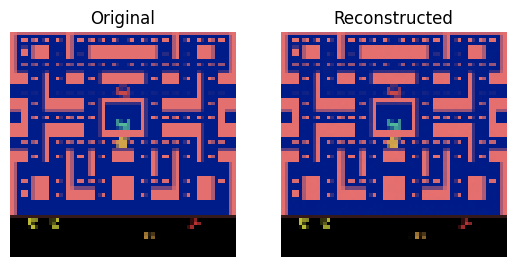

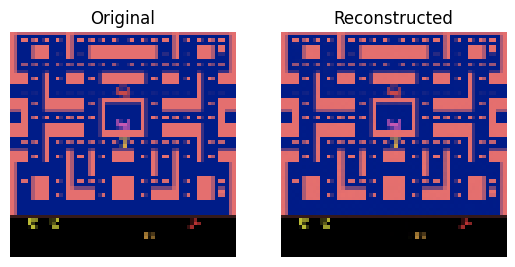

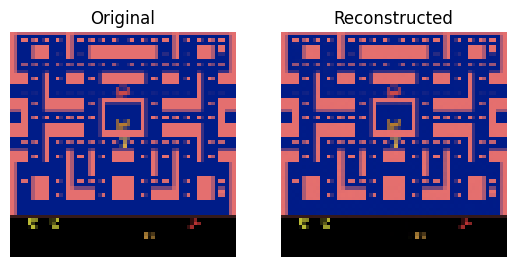

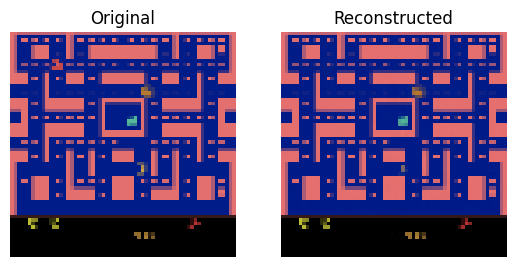

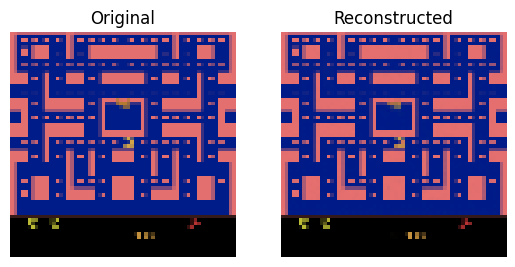

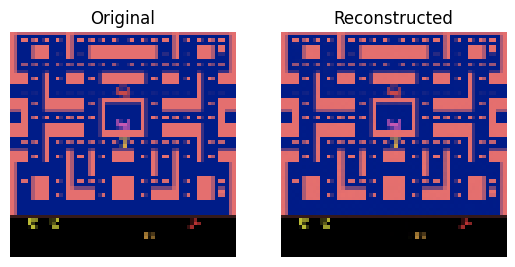

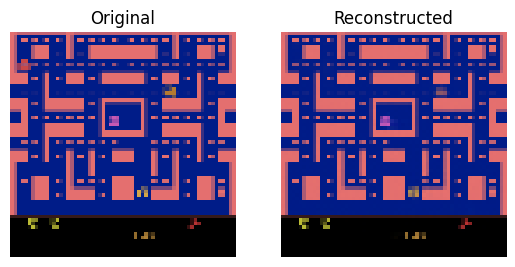

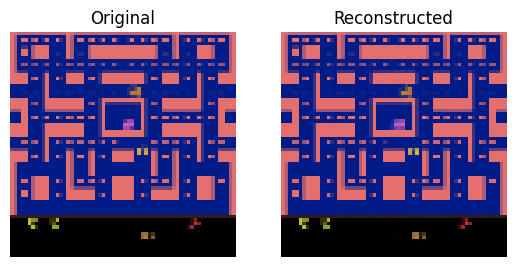

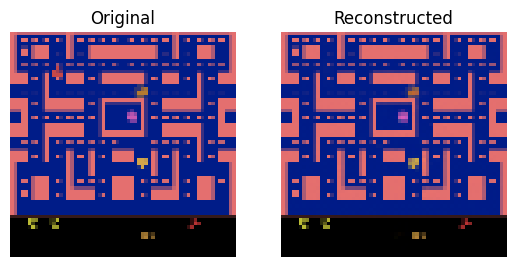

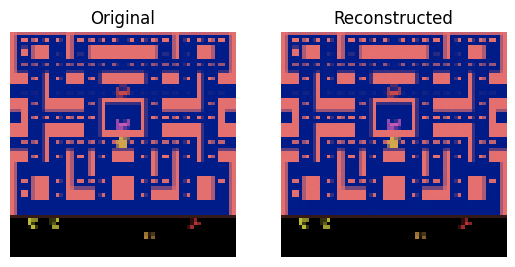

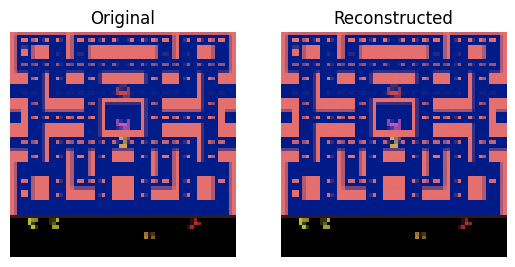

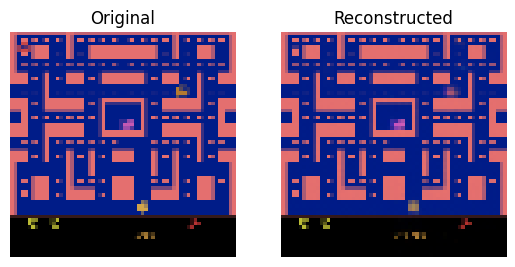

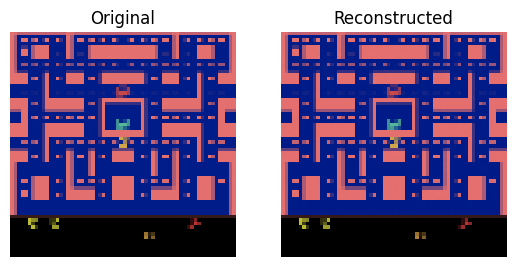

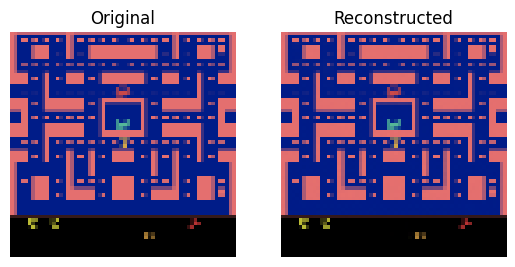

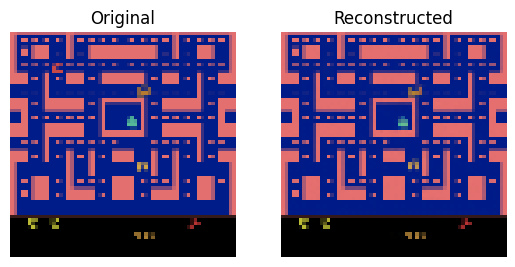

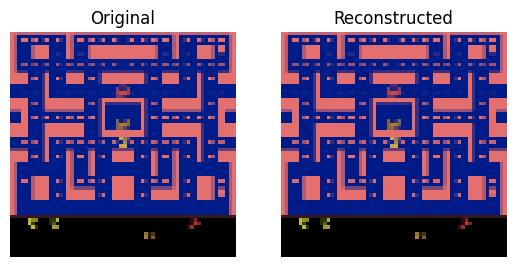

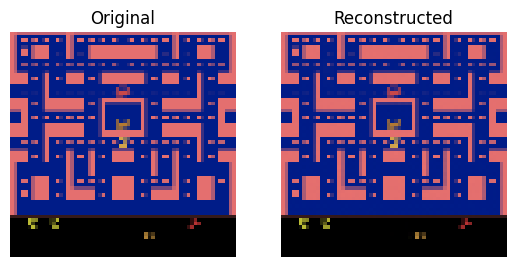

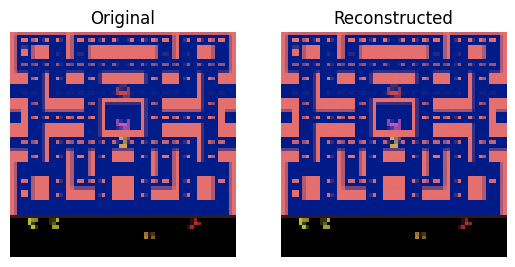

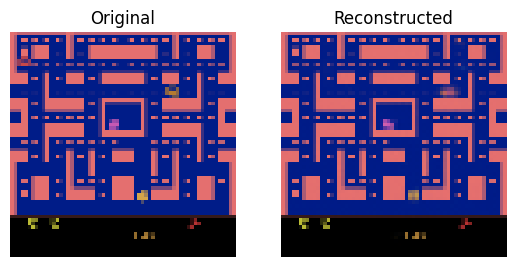

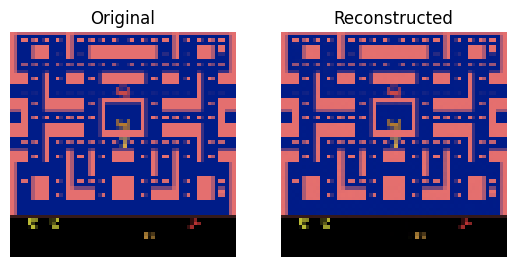

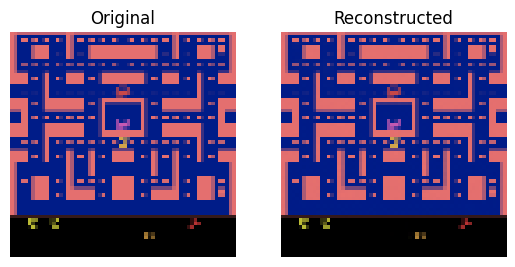

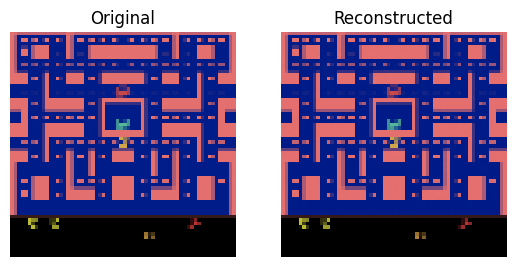

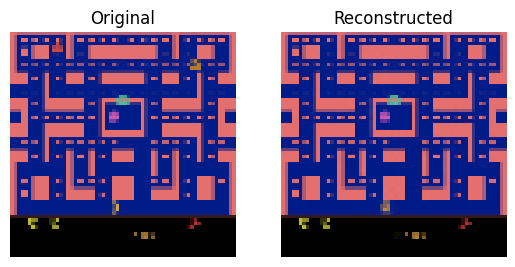

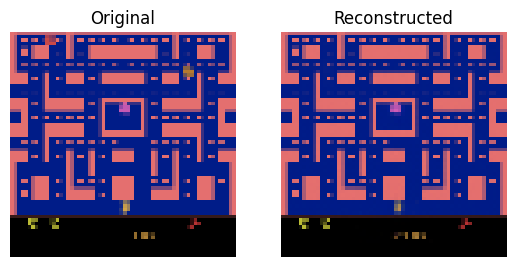

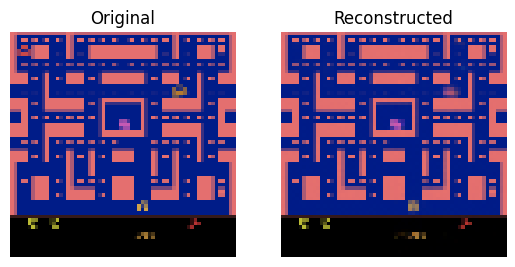

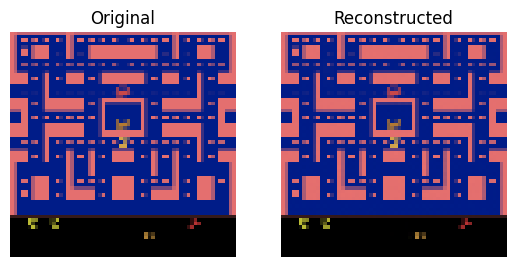

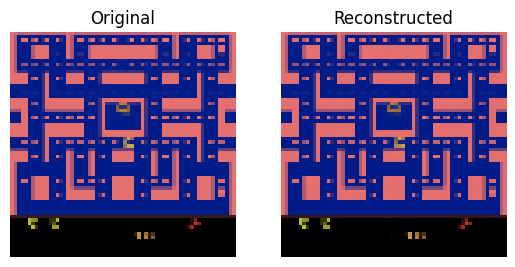

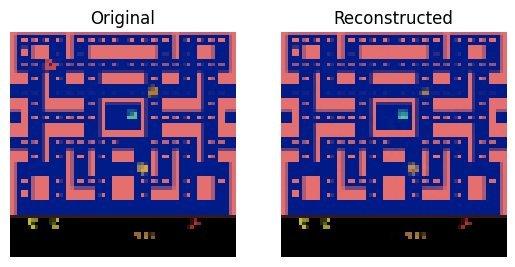

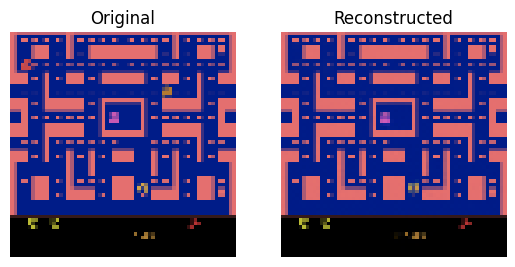

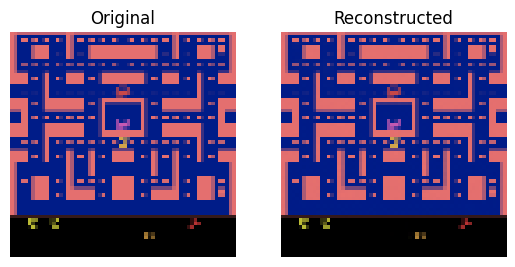

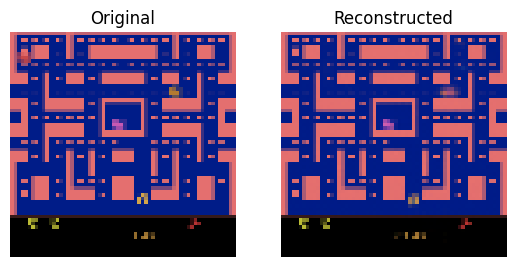

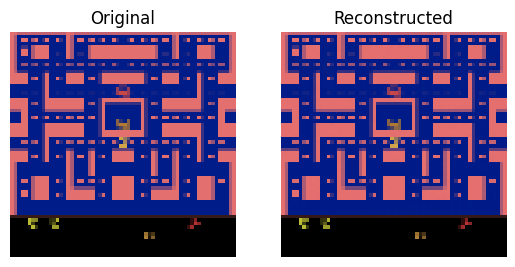

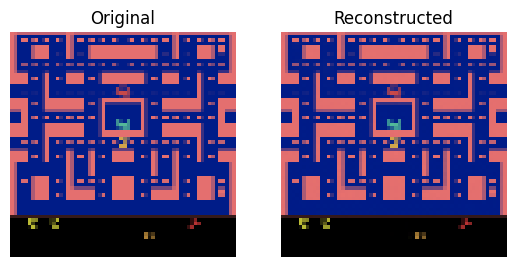

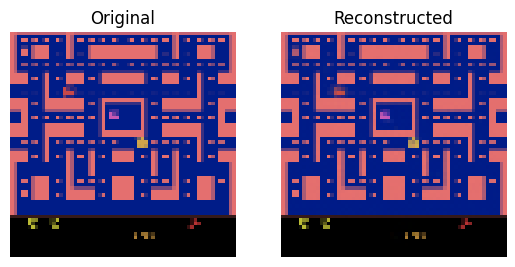

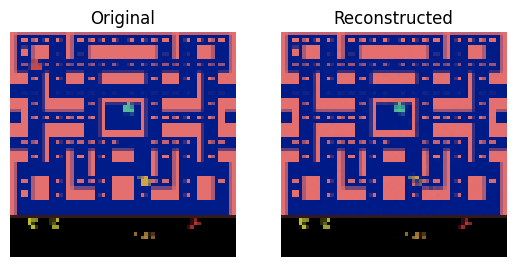

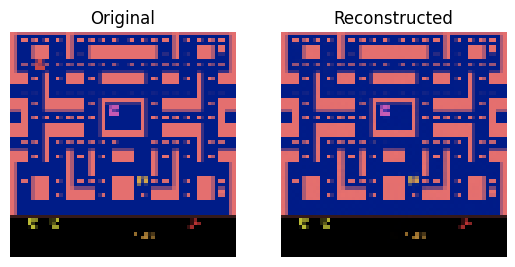

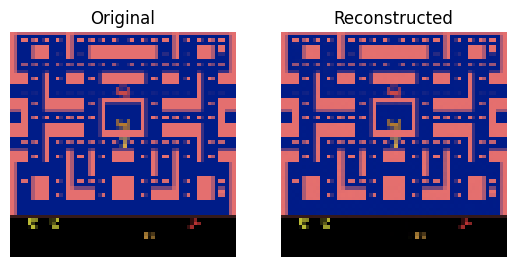

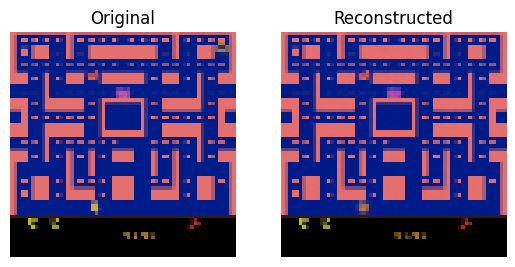

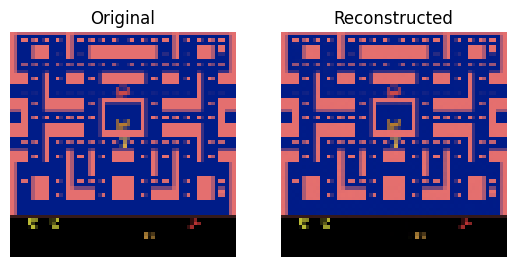

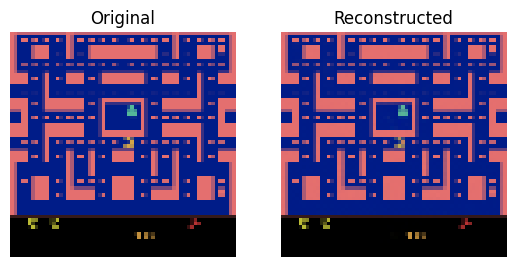

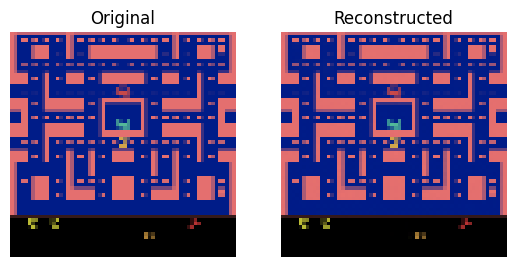

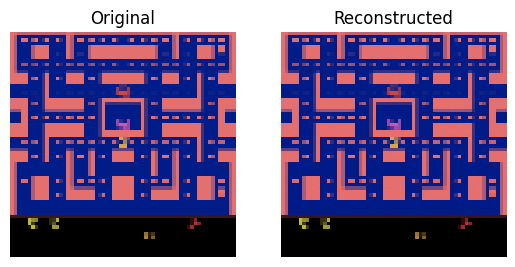

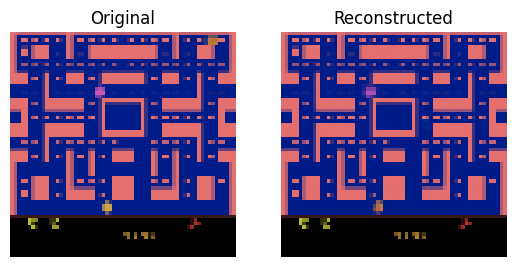

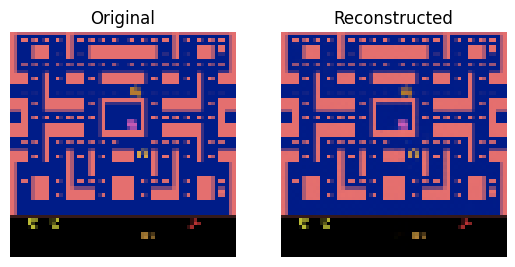

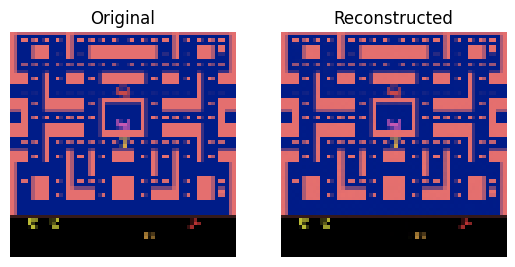

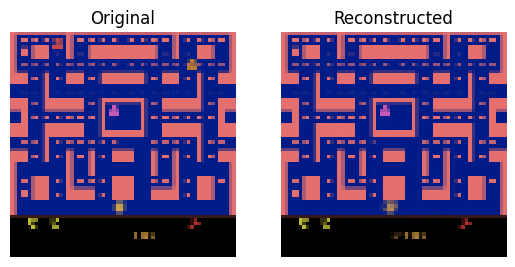

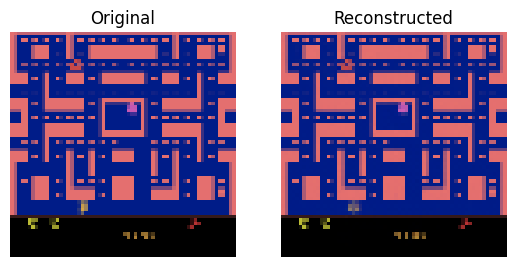

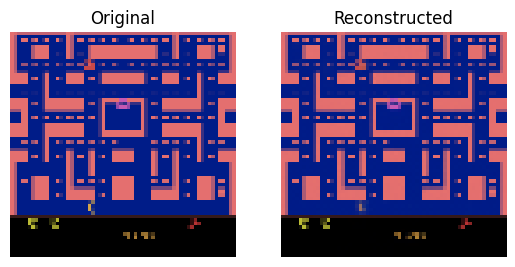

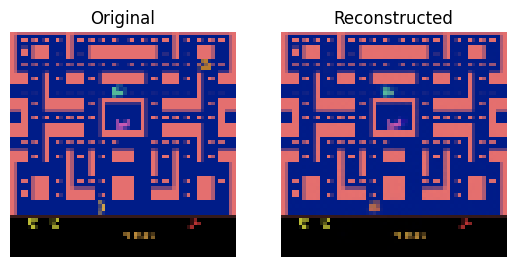

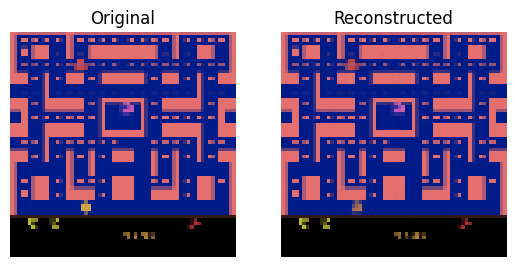

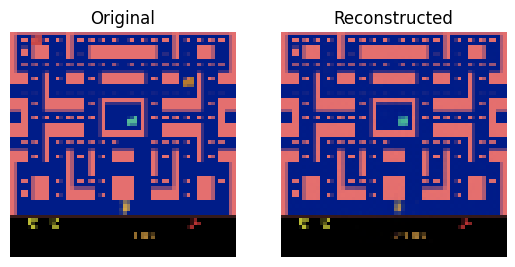

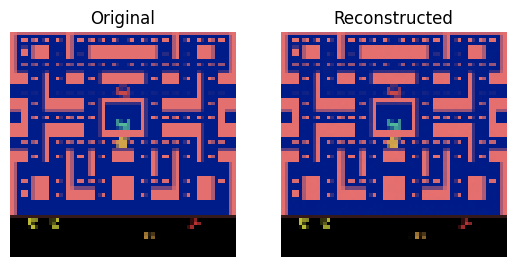

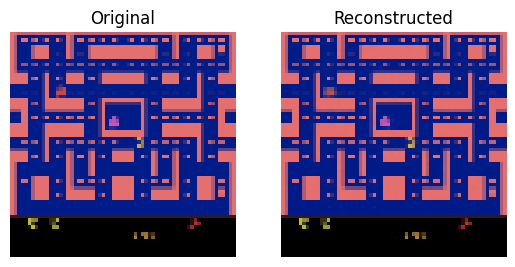

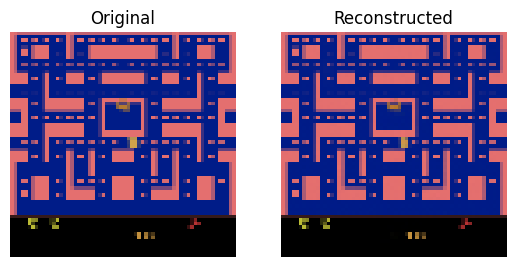

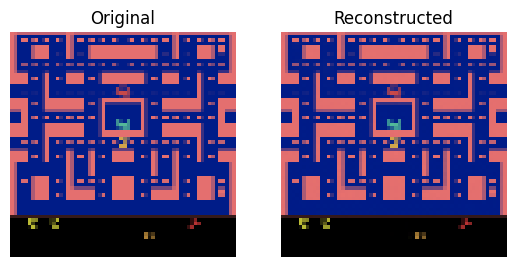

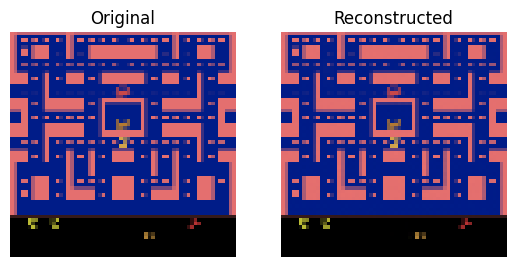

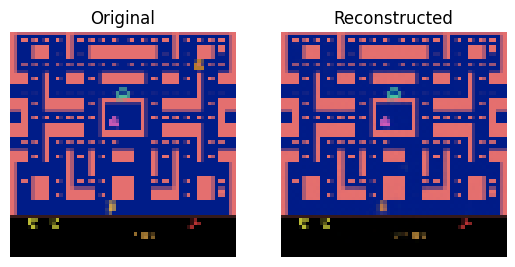

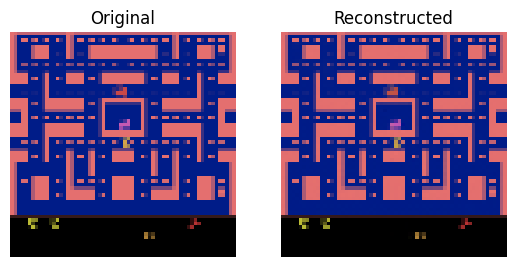

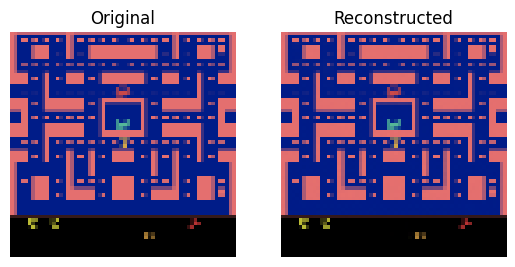

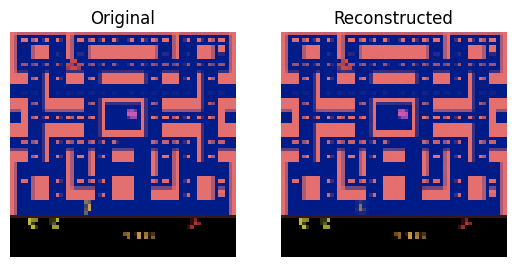

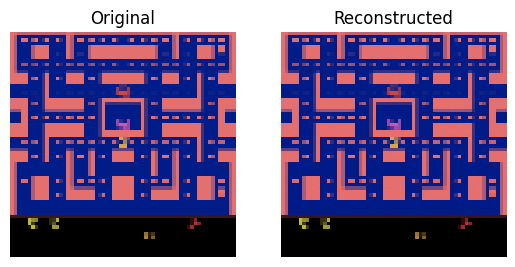

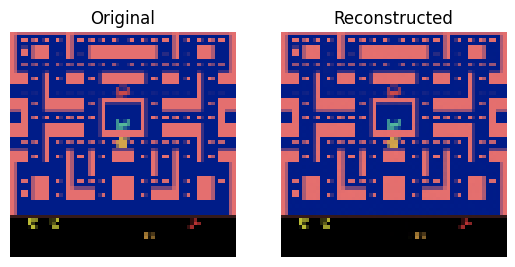

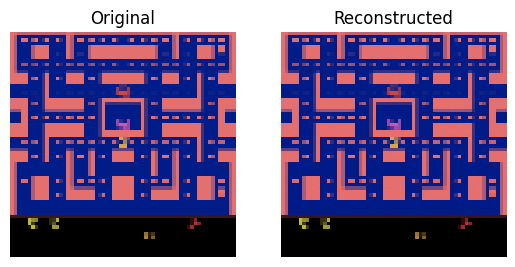

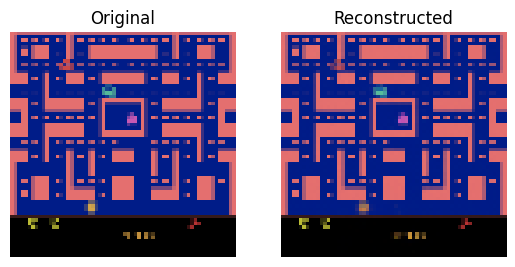

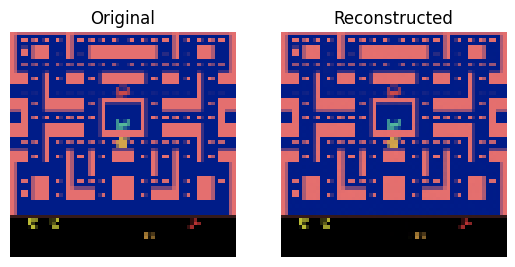

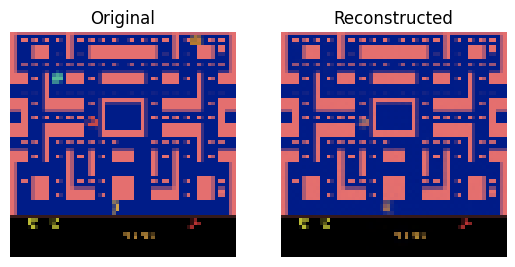

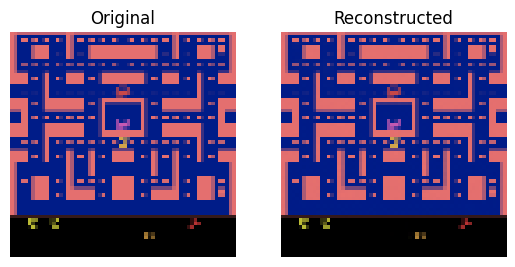

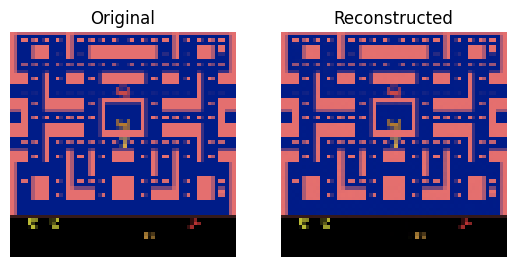

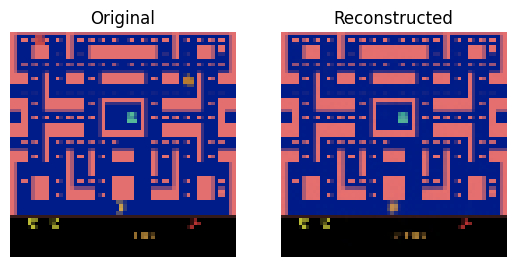

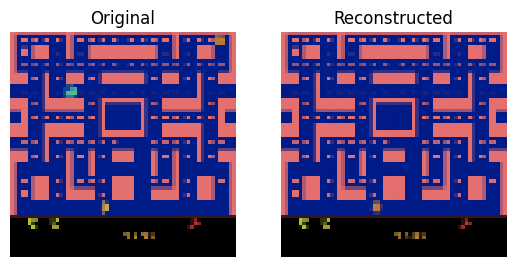

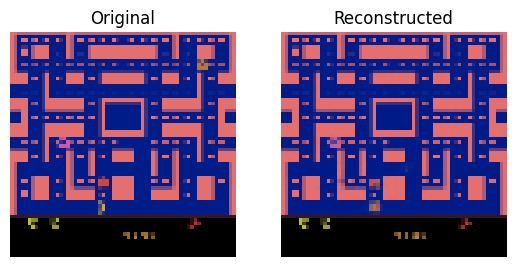

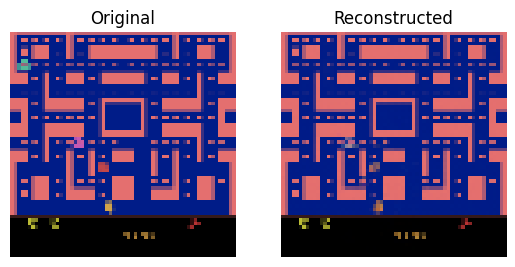

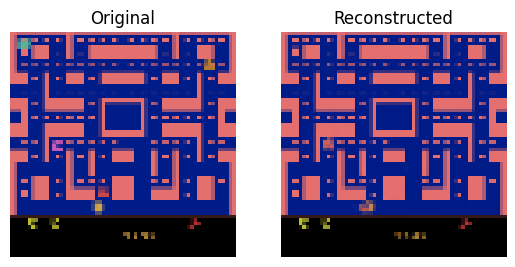

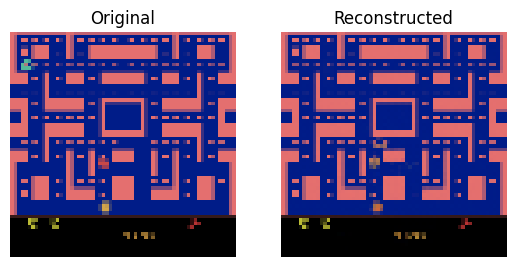

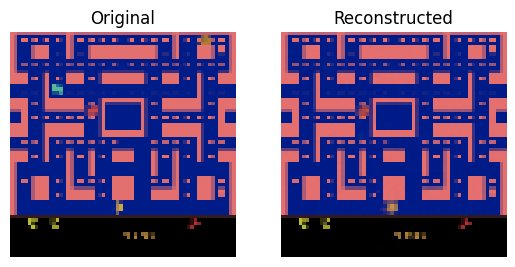

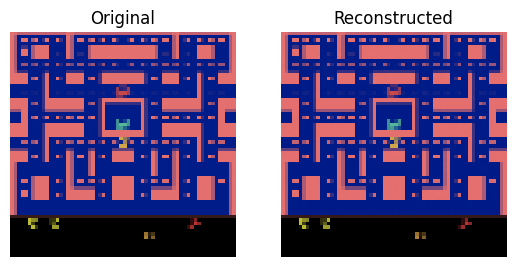

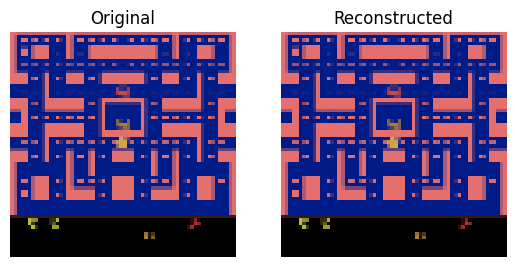

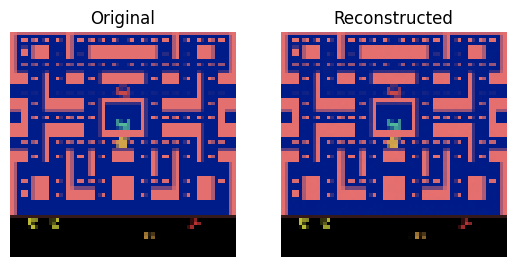

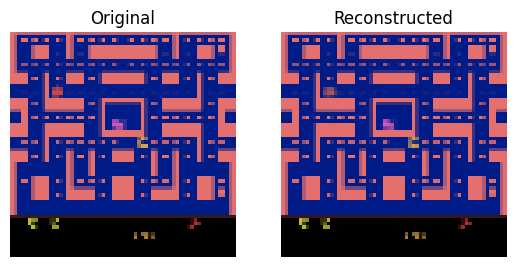

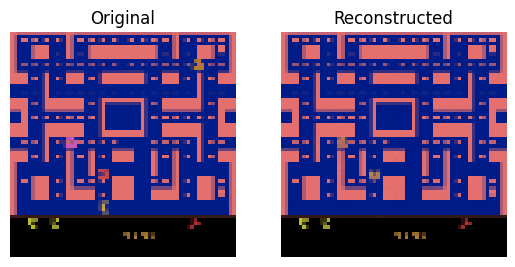

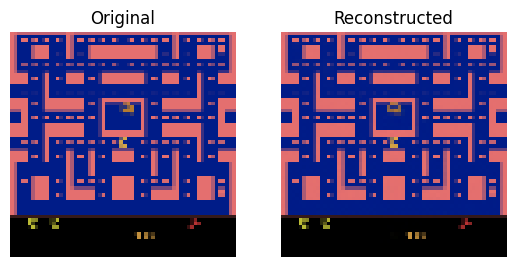

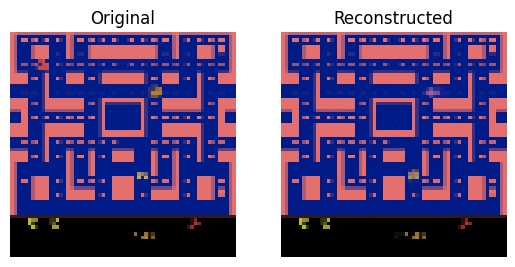

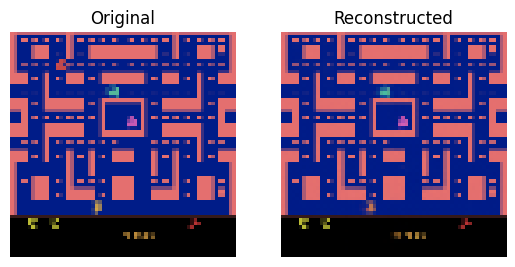

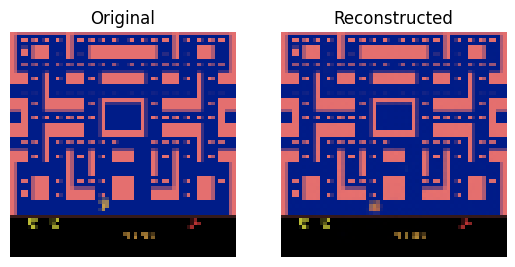

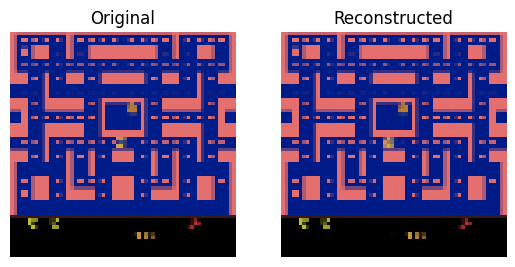

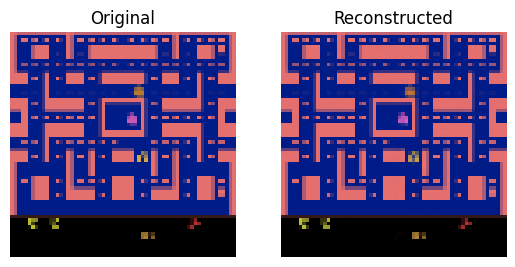

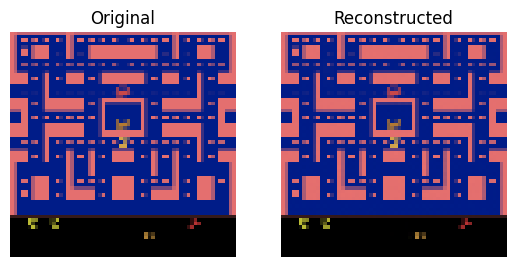

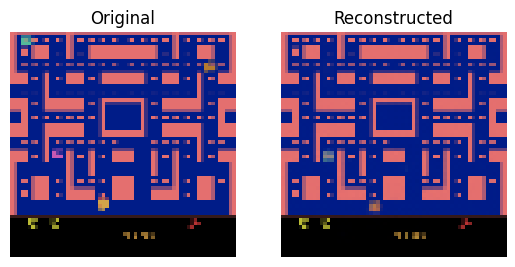

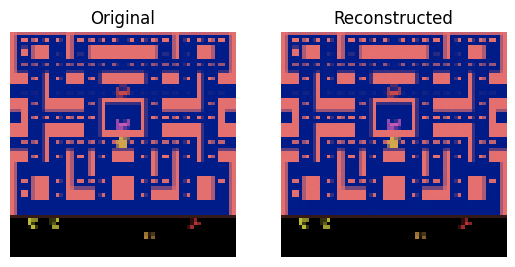

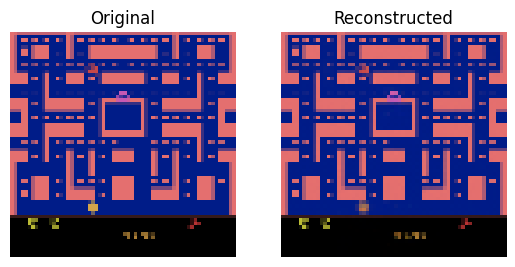

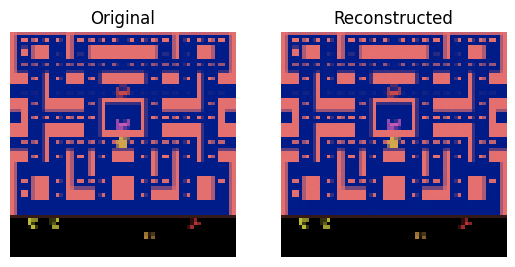

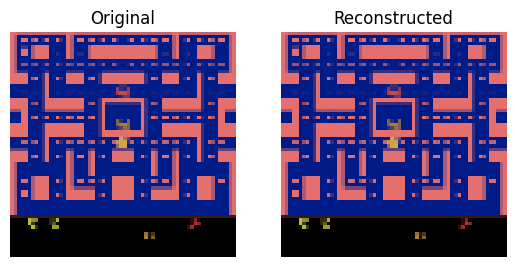

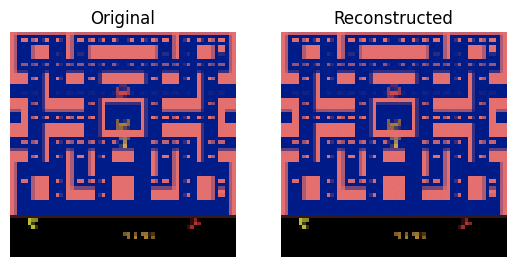

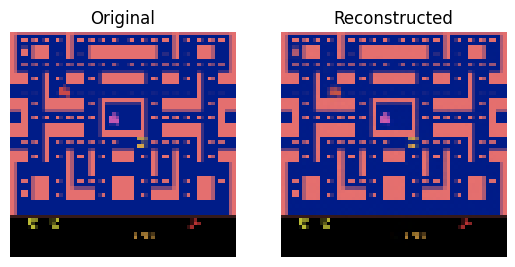

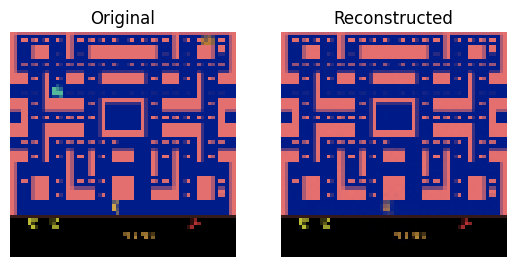

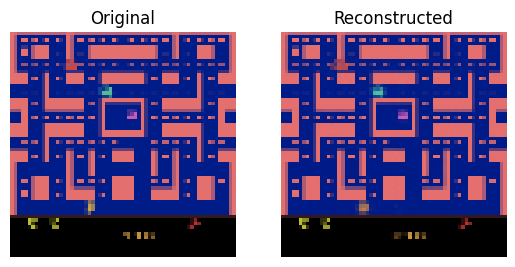

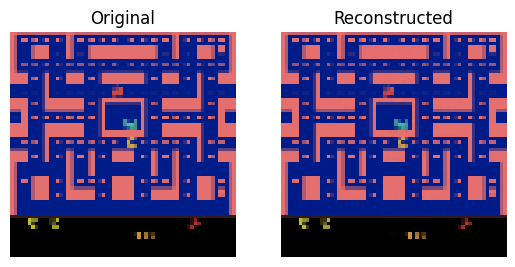

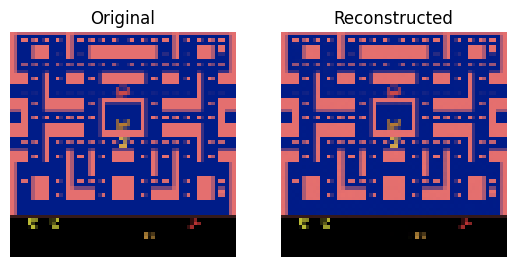

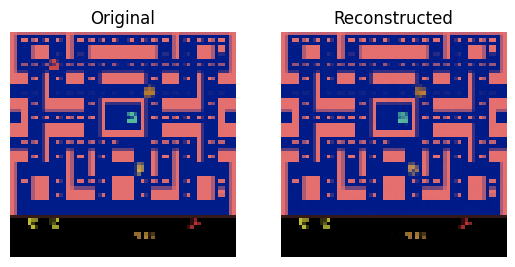

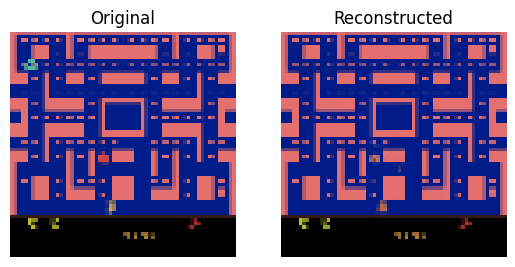

In [13]:
eval_on_test_data(model_infer, 100, test_dataset)

## Snapshot Pretrained VAE Model

In [14]:
model_infer.save_weights("vqvae.h5")

# Train Dynamics Model (RNN)

## Load Pretrained VAE Model Snapshot

In [28]:
settings = DreamerSettings([1], [64, 64, 3], [4, 4, 64], [32, 1024], [512])
_, model_infer2, model_obs_enc, model_dream_render, vq_codebook = create_model(settings)
model_infer2.load_weights("vqvae.h5")


def compose_model(enc_model, dec_model):
    model_in = Input(settings.obs_dims)
    z_quantized, z_cat = enc_model(model_in)
    model_out = dec_model(z_cat)
    return Model(inputs=model_in, outputs=model_out)


comp_model = compose_model(model_obs_enc, model_dream_render)
eval_on_test_data(comp_model, 10, test_dataset)

The following Variables were used a Lambda layer's call (lambda_10), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/embeddings:0' shape=(32, 1024) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


ValueError: Exception encountered when calling layer 'lambda_10' (type Lambda).

in user code:

    File "<ipython-input-26-cdf74ff0a75f>", line 46, in lookup  *
        quantized = self.reshape(quantized)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/reshaping/reshape.py", line 118, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer 'reshape' (type Reshape).
    
    total size of new array must be unchanged, input_shape = [32], output_shape = [4, 4, 64]
    
    Call arguments received by layer 'reshape' (type Reshape):
      • inputs=tf.Tensor(shape=(None, 32), dtype=float32)


Call arguments received by layer 'lambda_10' (type Lambda):
  • inputs=tf.Tensor(shape=(None, 1024), dtype=float32)
  • mask=None
  • training=None

## Generate RNN Dataset

In [ ]:
def preprocess_obs(obs, cat: bool):
    obs = tf.image.resize(obs, settings.obs_dims[:2])
    z_quant, z_cat = obs_enc(tf.cast(obs, dtype=tf.float32) / 255.0)
    z_quant = tf.reshape(z_quant, (z_quant.shape[0], -1))
    return z_cat if cat else z_quant


def preprocess_action(a, rnn_units):
    return tf.one_hot(a, depth=rnn_units, dtype=tf.float32)


def sample_trajectory(env: gym.Env, proprocess_image, preprocess_action):
    all_obs = []
    all_actions = []
    done = False
    obs = env.reset()
    all_obs.append(obs)
    while not done:
        action = env.action_space.sample()
        all_actions.append(action)
        obs, reward, done, _ = env.step(action)
        all_obs.append(obs)
    s0_quant = proprocess_image(np.array(all_obs[:-1]), False)
    s1_cat = proprocess_image(np.array(all_obs[1:]), True)
    a0_quant = preprocess_action(np.array(all_actions))
    assert s0_quant.shape[1:] == (1024)
    assert s1_cat.shape[1:] == (32, 32)
    assert a0_quant.shape[1:] == (512)
    return s0_quant.shape[0], (s0_quant, s1_cat, a0_quant)


def traj_to_timeseries(s0, s1, a, series_steps=50, overlap=40):
    total_steps = s0.shape[0]
    assert s0.shape[0] == s1.shape[0]
    assert s1.shape[0] == a.shape[0]
    offset = series_steps - overlap

    i = 0
    s0_slices = []
    s1_slices = []
    a_slices = []
    while i + series_steps < total_steps:
        s0_slices.append(s0[i:i+series_steps])
        s1_slices.append(s1[i:i+series_steps])
        a_slices.append(a[i:i+series_steps])
        i += offset

    num_examples = len(s0_slices)
    dataset = tf.data.Dataset.from_tensor_slices(tensors=(
        np.array(s0_slices), np.array(s1_slices), np.array(a_slices)))
    return num_examples, dataset


def concat_datasets(datasets: List[tf.data.Dataset]) -> tf.data.Dataset:
    ds = datasets[0]
    for i in range(len(datasets) - 1):
        ds = ds.concatenate(datasets[i+1])
    return ds


def generate_rnn_datasets(
        env: gym.Env, settings: DreamerSettings, obs_enc: Model,
        batch_size: int, timesteps: int, dt: int=50, overlap: int=40, rnn_units: int=512):

    action_encoder = lambda a: preprocess_action(a, settings.hidden_dims[0])
    traj_datasets = []
    sampled_steps = 0
    for i in tqdm(range(timesteps)):
        if i < sampled_steps:
            continue
        steps, dataset = sample_trajectory(env, preprocess_obs, action_encoder)
        sampled_steps += steps
        traj_datasets.append(dataset)

    timeseries = [traj_to_timeseries(s0, s1, a0, dt, overlap) for s0, s1, a0 in traj_datasets]
    num_examples = sum([i for i, _ in timeseries])
    print(f"num_examples {num_examples}")

    num_eval_examples = ceil((num_examples // batch_size) * 0.1) * batch_size
    dataset = concat_datasets([ds for _, ds in timeseries])
    dataset = dataset.map(lambda s0, s1, a: (tf.concat((s0, a), axis=-1), s1))
    train_dataset = dataset.skip(num_eval_examples)
    eval_dataset = dataset.take(num_eval_examples)
    train_dataset = train_dataset.shuffle(100)
    train_dataset = train_dataset.batch(batch_size)
    eval_dataset = eval_dataset.batch(batch_size)
    return train_dataset, eval_dataset

In [ ]:
env = gym.make("ALE/MsPacman-v5")
rnn_train, rnn_eval = generate_rnn_datasets(
    env, settings, model_obs_enc, 64, 50_000)

batch = next(iter(rnn_train))
x, y = batch
print(x.shape)
print(y.shape)

In [ ]:
def create_dynamics_rnn(settings: DreamerSettings):
    rnn = Bidirectional(GRU(settings.hidden_dims[0], return_sequences=True))
    dropout = Dropout(rate=settings.dropout_rate)
    dense_upscale = Dense(settings.repr_dims_flat, activation="linear")
    reshape = Reshape((-1, settings.repr_dims[0], settings.repr_dims[1]))
    softmax = Activation("softmax")
    extract_last_step = Lambda(lambda x: x[:, -1])
    sample_z_cat = tfp.layers.OneHotCategorical(settings.repr_dims)

    rnn_in = Input([None, settings.rnn_input_dims_flat])
    rnn_out_series = softmax(reshape(dense_upscale(dropout(rnn(rnn_in)))))
    rnn_out_z_cat = sample_z_cat(extract_last_step(rnn_out_series))

    rnn_train = Model(inputs=rnn_in, outputs=rnn_out_series)
    rnn_infer = Model(inputs=rnn_in, outputs=rnn_out_z_cat)
    return rnn_train, rnn_infer


def create_rnn_embedding_preprocessing(settings: DreamerSettings):
    flatten_z = Reshape((-1, settings.z_quant_dims_flat))
    concat_za = Concatenate()
    z0_init = Input([None] + settings.obs_enc_dims)
    a0_init = Input([None, settings.padded_action_dims])
    x0 = concat_za((flatten_z(z0_init), a0_init))
    return Model(inputs=[z0_init, a0_init], outputs=x0)


model, rnn_infer = create_dynamics_rnn(settings)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(epochs=30, x=rnn_train, validation_data=rnn_eval)

In [ ]:
!apt update && apt install -y ffmpeg

In [ ]:
x0_initializer = lambda: next(iter(rnn_eval))[0][:1]
rnn_embed = create_rnn_embedding_preprocessing(settings)
za_embed = lambda z0_cat, a0: rnn_embed((tf.expand_dims(vq_codebook(z0_cat), axis=0), a0))
actor = lambda obs: tf.one_hot(env.action_space.sample(), depth=512)


def sample_frame(x0):
    z1_cat = rnn_infer(x0)
    a0_quant = tf.expand_dims(tf.expand_dims(actor(None), axis=0), axis=0)
    x1 = za_embed(z1_cat, a0_quant)

    s1_dream = tf.squeeze(model_dream_render(z1_cat))
    s1_dream = tf.cast(tf.clip_by_value(s1_dream * 255.0, 0.0, 255.0), dtype=tf.uint8).numpy()
    return s1_dream, x1


def sample_video_frames(steps: int):
    x = x0_initializer()
    for step in range(steps):
        frame, x = sample_frame(x)
        yield frame

In [ ]:
def show_subplot(original):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze())
    plt.axis("off")
    plt.show()

for frame in sample_video_frames(200):
    show_subplot(frame)

In [ ]:
from subprocess import Popen, PIPE


def render_dream_video(out_file: str="output.mp4"):
    proc_call = [
        "ffmpeg",
        "-framerate", "1",
        "-f", "image2pipe",
        "-i", "-",
        "-c:v", "libx264",
        "-r", "30",
        "-pix_fmt", "yuv420p",
        out_file
    ]
    with Popen(proc_call, stdout=PIPE, stdin=PIPE, stderr=PIPE) as process:
        raw_bytes = bytes()
        for frame in sample_video_frames(200):
            png_bytes = Image.fromarray(frame).tobytes("xbm", "rgb")
            raw_bytes += bytes("\n".encode("ascii")) +  png_bytes
        stdout, _ = process.communicate(raw_bytes)
        print(stdout.decode('ascii'))


render_dream_video()

In [ ]:
!ls -la | grep output.mp4

In [ ]:
!ffmpeg --help